# Programming Homework 1

---

## Group 04

- **Brian Huynh** (476188)  
- **Paula Winter** (409827)  
- **Paul Budden** (484284)  
- **Anar Alizade** (477200)

---




## Table of Contents

**I. [Coding Implementation](#I)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.1 [Import Built-in Libraries](#I.1)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.2 [Basis Functions In The Homework](#I.2)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.3 [Useful FEM Frameworks](#I.3)**   
&nbsp;&nbsp;&nbsp;&nbsp;**I.4 [Plotting Functions](#I.4)**

**II. [Exercises](#II)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.1 [Exercise 1](#II.1)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.2 [Exercise 2](#II.2)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.3 [Exercise 3](#II.3)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.4 [Bonus Exercise 1](#II.4)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.5 [Bonus Exercise 2](#II.5)**



The following order of completion needs to be completed:
1. code the functions 'grid'(linear case), 'assembleMatrix'(linear case), 'rhsConstant'(linear case), 'FEM1DConstant'(linear case) 
2. code the functions 'solConstant', 'interpolate'(linear case), 'L2Error'(linear case) 
3. code the functions 'rhsDelta'(linear case), 'FEM1DDelta'(linear case), 'solDelta' 
4. complete the functions 'grid'(quadratic case), 'assembleMatrix'(quadratic case), 'rhsConstant'(quadratic case), 'interpolate'(quadratic case), 'L2Error'(quadratic case) 
5. complete the functions 'rhsDelta'(quadratic case) 

I. Coding Implementation <a name="I"></a>
=================

I.1 Import Built-in Libraries <a name="I.1"></a>
--------------------------------

In [59]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csc_matrix
from scipy.sparse.linalg import spsolve
%matplotlib inline

### Importing Libraries

1. **NumPy (`numpy`)**  
   Import the NumPy library, a fundamental package for numerical computing in Python. It provides arrays, matrices, and a wide range of mathematical functions for fast numerical operations.  

2. **`quad` from SciPy (`scipy.integrate`)**  
   Used for numerical integration, i.e., calculating the area under a curve. This is helpful for tasks such as computing definite integrals in your code.  

3. **Matplotlib's `pyplot` (`matplotlib.pyplot`)**  
   Provides tools for creating plots and visualizations. We typically import it as `plt` and use it to generate line plots, scatter plots, bar charts, etc.  

4. **Sparse Matrices (`scipy.sparse`)**  
   - **`spdiags`**: Creates a sparse matrix from diagonals, which is memory-efficient when working with large matrices containing mostly zeros.  
   - **`csc_matrix`**: Converts a matrix into Compressed Sparse Column (CSC) format, optimized for fast arithmetic and matrix operations on sparse data.  

5. **Solving Sparse Linear Systems (`scipy.sparse.linalg`)**  
   - **`spsolve`**: Solves linear systems of the form `Ax = b` where `A` is a sparse matrix. This is much faster than standard dense solvers for large, mostly-zero matrices.  

6. **`%matplotlib inline`** (Jupyter magic command)  
   Ensures that all plots created with Matplotlib are displayed directly within the notebook cells.


I.2 Basic Functions In The Homeworks<a name="I.2"></a>
--------------------------------

### Linear Basis Functions

Linear basis functions are defined using **two nodes per element**.  
For node *i*, the basis function is given by:

$$
\phi_i(x) = 
\begin{cases}
 \dfrac{x - x_{i-1}}{x_i - x_{i-1}}, & \text{for } x \in (x_{i-1}, x_i] \\
 \dfrac{x_{i+1} - x}{x_{i+1} - x_i}, & \text{for } x \in (x_i, x_{i+1}] \\
 0, & \text{elsewhere}
\end{cases}
$$

In the following example, the basis function corresponds to  
$\phi_i(x)$ with $x_{i-1} = 0$, $x_i = 1$, and $x_{i+1} = 2$.

Notice that $\phi_i(x)$ *overlaps* with its neighboring basis functions  
$\phi_{i-1}(x)$ and $\phi_{i+1}(x)$, but is **nonzero** only on the two adjacent elements.

The illustration below shows two elements of the domain:
- **First element:** $x \in (0, 1]$  
- **Second element:** $x \in (1, 2]$

Together, these basis functions form a continuous piecewise-linear approximation over the domain.


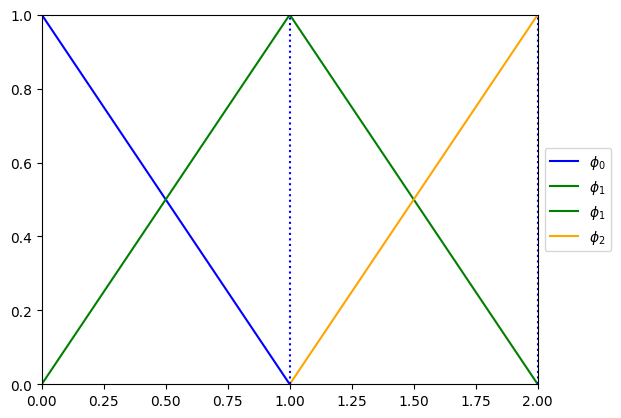

In [2]:
x1 = np.linspace(0, 1, 1000)
x2 = np.linspace(1, 2, 1000)
fig = plt.figure()

plt.plot(x1, 1 - x1, color='blue', label=r'$\phi_0$')
plt.plot(x1, x1, color='green', label=r'$\phi_1$')
plt.plot(x2, 2 - x2, color='green', label=r'$\phi_1$')
plt.plot(x2, x2 - 1, color='orange', label=r'$\phi_2$')

plt.axvline(x=1, color='blue', linestyle=':')
plt.axvline(x=2, color='blue', linestyle=':')

plt.margins(x=0)
plt.margins(y=0)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Program Structure

What we will implement in the code:

- **`def grid(...)`** – Creates the computational grid or mesh used for numerical calculations.  
- **`def assembleMatrix(...)`** – Constructs the stiffness matrix, which represents the system’s coefficients in the finite element formulation.  
- **`def assembleRHS(...)`** – Builds the right-hand side (RHS) vector that incorporates source terms or boundary conditions.  
- **`def linEqsSolver(...)`** – Solves the resulting linear system of equations to obtain the numerical solution.


I.3 Useful Main FEM Frameworks <a name="I.3"></a>
--------------------------------

### Step 1 — Create the grid

Use the `grid(N, ansatz='linear')` function to build the FEM mesh (node coordinates) on [0, 1].

- Parameters  
  - `N` — number of elements (integer)  
  - `ansatz` — `'linear'` (default) or `'quad'` (quadratic)

- Returns: 1D NumPy array of node coordinates.


In [3]:
def grid(N, ansatz='linear', nonuniform=False):
    """Generate uniform or non-uniform 1D grid."""
    
    node_count = N + 1 if ansatz == 'linear' else 3*N - (N - 1)

    ## each element has 2 nodes for linear ansatz. so the total nodes are N+1. Else is for quadratic ansatz (each element has 3 nodes, but the middle nodes are shared))
    
    vec = np.linspace(0, 1, node_count)
    
    if nonuniform:
        vec = vec**2  # non-uniform mapping
    
    return vec

### Step 2 — Set up the stiffness matrix

The stiffness matrix can directly be computed via
$$
A_{ij} = \int_\Omega \phi'_i(x) \, \phi'_j(x) \, dx \quad
$$
where the basis functions shall be either linear or quadratic ansatz functions. 
- The integrals can be precomputed.
- In regions where the basis functions do not 'overlap', the integral is 0.
- The solution is known on the boundaries. You therefore only need to compute a solution for the unknown inner nodes of the domain. Choose the size of the stiffness matrix correspondingly.

In [5]:
def assembleMatrix(lattice):
    
    n = len(lattice)
    
    main = np.zeros(n)
    ## main diagonal
    
    upper = np.zeros(n-1)
    ## upper diagonal
    
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h

    return diags([main, upper, upper], [0, -1, 1], format='csc')

Loops over neighboring nodes `j` for a given node `i`.

In **1D FEM** (Finite Element Method) with **linear basis functions**, each node only interacts with its immediate neighbors:  
`(i-1, i, i+1)`.

Python’s `range` excludes the upper bound, so:

```python
range(i-1, i+2)

### Step 3 — Assemble the right-hand side (RHS)

### Right-Hand Side Computation in FEM

The right-hand side of the equation can be computed as:

$$
b_i(x) = \int_\Omega f(x) \, \phi_i(x) \, dx
$$

#### Notes for Implementation

- For a more general-purpose FEM solver, the function can be defined as:  

```python
def rhs(function, lattice, ansatz='linear'):


In [6]:
## Right-hand side assembly for f = 1
def rhsConstant(lattice):
    """Assemble right-hand side vector for f = 1."""
    n = len(lattice)
    b = np.zeros(n)
    ## initialize the right-hand side vector
    for i in range(n - 1):
        h = lattice[i + 1] - lattice[i]
        ##compute the element length between nodes i and i+1
        b[i] += h / 2
        ## each element contributes h/2 to both nodes
        b[i + 1] += h / 2
        ## so we add h/2 to both b[i] and b[i+1]
    return b

In [ ]:
def rhsDelta(lattice):
    """RHS vector for delta(x-0.5)."""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        if lattice[i] <= 0.5 <= lattice[i+1]:
            ##Checks if the delta source at x = 0.5 lies inside this element.
            ##Only the element containing x=0.5 gets a non-zero contribution.
            h = lattice[i+1] - lattice[i]
            ##h is the length of the element containing the delta.
            b[i] += 2 * (lattice[i+1] - 0.5)/h
            ##RHS value for the left node of the element.
            b[i+1] += 2 * (0.5 - lattice[i])/h
            ##RHS value for the right node of the element.
    return b


Creates an **N×N** zero matrix, where **N** is the number of nodes.
If `(ansatz == 'linear')`:

Each basis function **Φᵢ(x)** is a piecewise linear "hat" function, nonzero only over two neighboring elements.

So each node **i** only interacts with its neighbors **i−1, i, i+1**.

`grad_Phi` is the derivative of the linear shape function:

$$
\Phi_i(x)
$$

`quad` numerically integrates:

$$
\nabla \Phi_i(x) \cdot \nabla \Phi_j(x)
$$

I.4 Plotting Functions <a name="I.3"></a>
--------------------------------

In [7]:
def interpolate(x, lattice, u):
    """ Interpolation on piecewise-linear grid."""
    if np.isscalar(x):
        x = np.array([x])
    x = np.clip(x, 0, 1)
    ## ensure x is within the domain [0, 1]

    u_interp = np.zeros_like(x)
    for k, xi in enumerate(x):
        i = np.searchsorted(lattice, xi) - 1
        ## find the element index containing xi
        i = np.clip(i, 0, len(lattice) - 2)
        ## ensure i is within valid range
        h = lattice[i + 1] - lattice[i]
        ## element length
        phi_left = (lattice[i + 1] - xi) / h
        ## linear shape function for left node
        phi_right = (xi - lattice[i]) / h
        ## linear shape function for right node
        u_interp[k] = phi_left * u[i] + phi_right * u[i + 1]
        ## interpolate using shape functions
    return u_interp


In [8]:
def FEM1DConstant(N):
    """Solve -u'' = 1 with Dirichlet BC u(0)=u(1)=0."""
    G = grid(N)
    A = assembleMatrix(G)
    ## Stiffness matrix
    b = rhsConstant(G)

    # Solve for interior nodes
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1, 1:-1], b[1:-1])
    ## Solve the linear system for interior nodes only (excluding boundary nodes)
    u[1:-1] = u_interior
    ## Assign the computed interior values back to the full solution vector

    # Analytical solution
    u_analytical = -0.5 * (G - 0.5) ** 2 + 1 / 8
    return G, u, u_analytical

In [9]:
def FEM1DDelta(N):
    G = grid(N)
    A = assembleMatrix(G)
    b = rhsDelta(G)
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1,1:-1], b[1:-1]) 
    u[1:-1] = u_interior
    u_analytical = np.where(G <= 0.5, 2*G, 2*(1-G))
    #This line defines the analytical solution for the PDE:
    #-u''(x) = 2δ(x - 0.5), u(0) = u(1) = 0
    # G is the vector of FEM nodes (grid points)
    # u_analytical will store the exact solution at each node
    # For x <= 0.5, the solution is u(x) = x
    # For x > 0.5, the solution is u(x) = 1 - x 
    # This creates a piecewise linear function peaking at x=0.5
    return G, u, u_analytical

II. Exercises <a name="II"></a>
=================
### II.1> Exercise 1 <a name="II.1"></a>

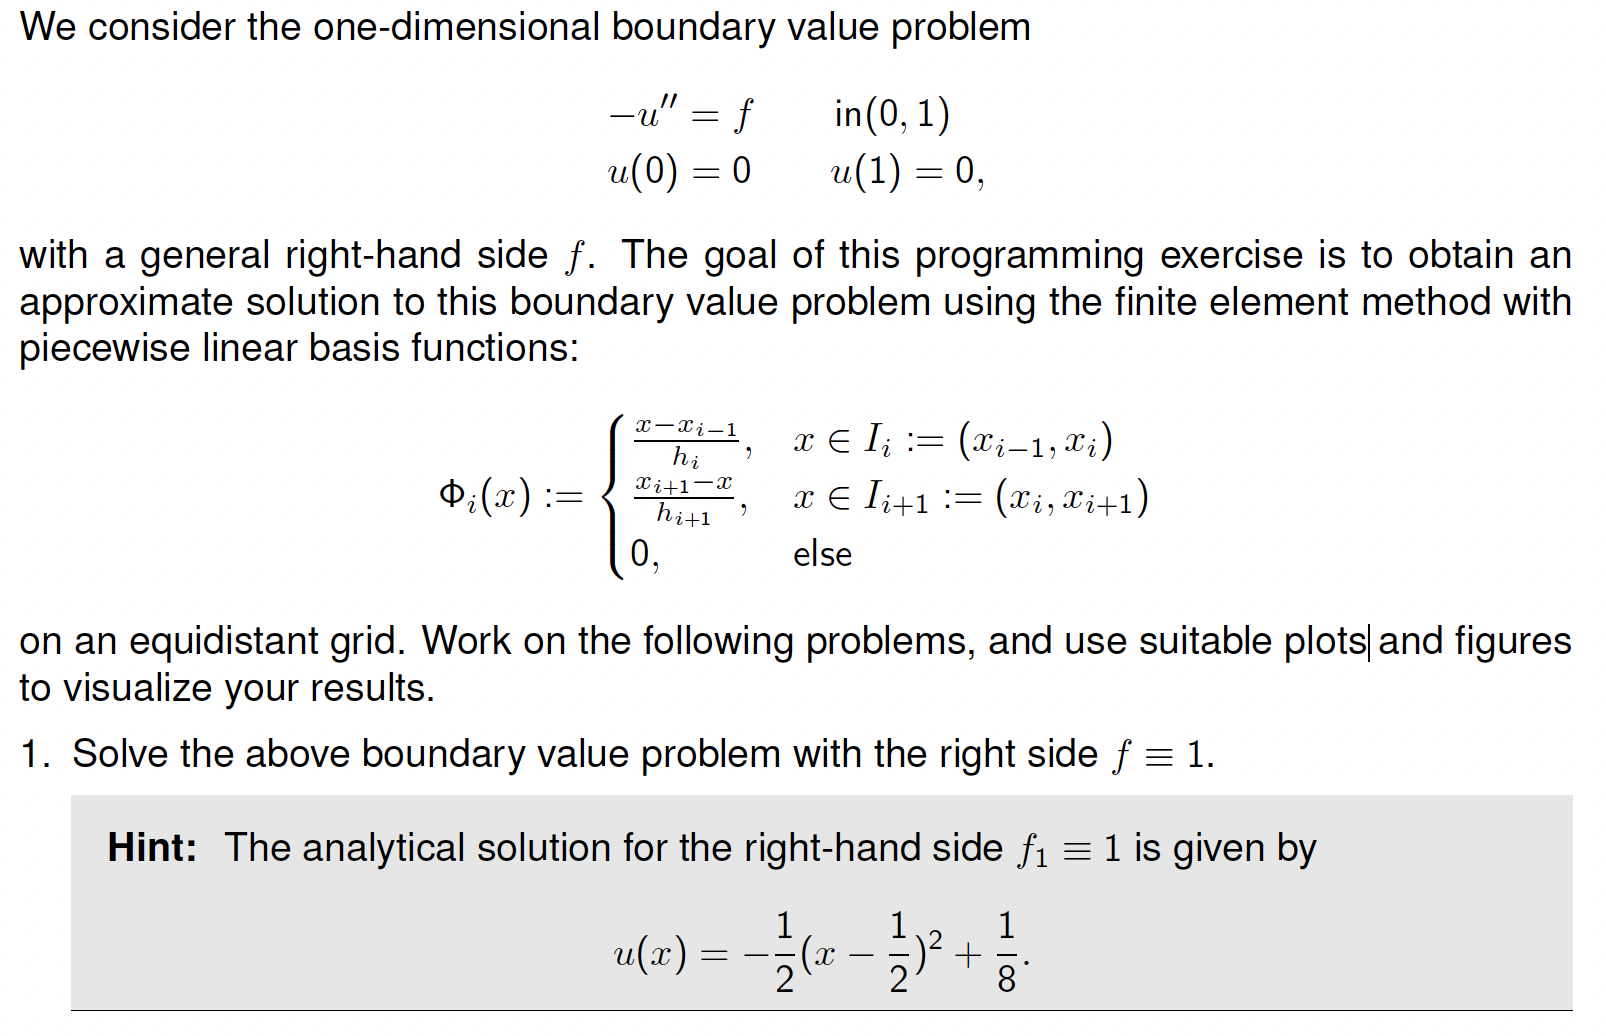

## Motivation how to approach the problem:
To assemble the stiffness matrix for a finite element method (FEM) problem using linear basis functions, we need to consider the contributions of each element to the global stiffness matrix. The matrix is constructed based on the interactions between the basis functions associated with each node in the mesh.
The following code snippet demonstrates how to assemble the stiffness matrix for a 1D FEM problem using linear basis functions:

```python
def assembleMatrix(lattice, ansatz='linear'):
    """
    Assembles the stiffness matrix for the FEM problem.   
    Parameters:
    - lattice: array of node coordinates
    - ansatz: 'linear' or 'quad' for basis function type
    Returns:
    - A: stiffness matrix
    """

How to solve: Numerically solve the equation using your FEM1DConstant function (or any finite element / finite difference method).

Use f(x) = 1 in your RHS vector.

Compare your numerical solution to the analytical solution above. 

## Case 1: $f = 1$ (linear)

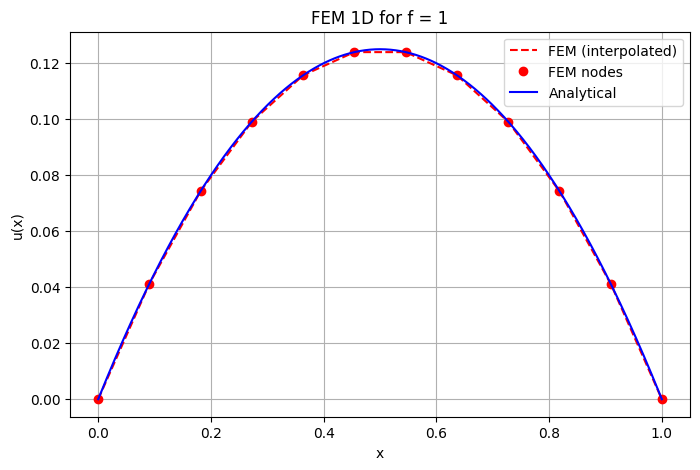

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve

# 1. Grid Generation
def grid(N, ansatz='linear', nonuniform=False):
    """Generate uniform or non-uniform 1D grid."""
    node_count = N + 1 if ansatz == 'linear' else 3*N - (N - 1)
    ## each element has 2 nodes for linear ansatz. so the total nodes are N+1. Else is for quadratic ansatz (each element has 3 nodes, but the middle nodes are shared))
    vec = np.linspace(0, 1, node_count)
    if nonuniform:
        vec = vec**2  # non-uniform mapping
    return vec


# 2. FEM Assembly (Analytical Form)
def assembleMatrix(lattice):
    """Assemble sparse stiffness matrix using analytical element matrices."""
    n = len(lattice)
    ## lattice is the grid points. n is the number of nodes. 
    main = np.zeros(n)
    ## values for the main diagonal of the stiffness matrix
    upper = np.zeros(n - 1)
    ## values for the main diagonal and upper diagonal of the stiffness matrix
    for i in range(n - 1):
        h = lattice[i + 1] - lattice[i]
        ##computes the element length 
        main[i] += 1 / h
        ## each element contributes 1/h to both nodes
        main[i + 1] += 1 / h
        upper[i] -= 1 / h
    A = diags([main, upper, upper], [0, -1, 1], format='csc')
    return A

## Right-hand side assembly for f = 1
def rhsConstant(lattice):
    """Assemble right-hand side vector for f = 1."""
    n = len(lattice)
    b = np.zeros(n)
    ## initialize the right-hand side vector
    for i in range(n - 1):
        h = lattice[i + 1] - lattice[i]
        ##compute the element length between nodes i and i+1
        b[i] += h / 2
        ## each element contributes h/2 to both nodes
        b[i + 1] += h / 2
        ## so we add h/2 to both b[i] and b[i+1]
    return b

## Task 2 with delta distribution (ignored it for task 1 ^^)
def rhsDelta(lattice):
    """Assemble right-hand side for a delta function at x = 0.5."""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n - 1):
        if lattice[i] <= 0.5 <= lattice[i + 1]:
            h = lattice[i + 1] - lattice[i]
            # Distribute delta contribution proportionally to linear shape functions
            b[i] += 2 * (lattice[i + 1] - 0.5) / h
            b[i + 1] += 2 * (0.5 - lattice[i]) / h
    return b

# 3. Solve Systems
def FEM1DConstant(N):
    """Solve -u'' = 1 with Dirichlet BC u(0)=u(1)=0."""
    G = grid(N)
    A = assembleMatrix(G)
    ## Stiffness matrix
    b = rhsConstant(G)

    # Solve for interior nodes
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1, 1:-1], b[1:-1])
    ## Solve the linear system for interior nodes only (excluding boundary nodes)
    u[1:-1] = u_interior
    ## Assign the computed interior values back to the full solution vector

    # Analytical solution
    u_analytical = -0.5 * (G - 0.5) ** 2 + 1 / 8
    return G, u, u_analytical


def FEM1DDelta(N):
    """Solve -u'' = delta(x-0.5) with Dirichlet BC u(0)=u(1)=0."""
    G = grid(N)
    A = assembleMatrix(G)
    b = rhsDelta(G)

    # Solve for interior nodes
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1, 1:-1], b[1:-1])
    ##This slices the matrix to remove the first and last rows and columns. 
    u[1:-1] = u_interior

    # Analytical solution
    u_analytical = np.where(G <= 0.5, G, 1 - G)
    return G, u, u_analytical


# 4. Interpolation and Plotting
def interpolate(x, lattice, u):
    """ Interpolation on piecewise-linear grid."""
    if np.isscalar(x):
        x = np.array([x])
    x = np.clip(x, 0, 1)
    ## ensure x is within the domain [0, 1]

    u_interp = np.zeros_like(x)
    for k, xi in enumerate(x):
        i = np.searchsorted(lattice, xi) - 1
        ## find the element index containing xi
        i = np.clip(i, 0, len(lattice) - 2)
        ## ensure i is within valid range
        h = lattice[i + 1] - lattice[i]
        ## element length
        phi_left = (lattice[i + 1] - xi) / h
        ## linear shape function for left node
        phi_right = (xi - lattice[i]) / h
        ## linear shape function for right node
        u_interp[k] = phi_left * u[i] + phi_right * u[i + 1]
        ## interpolate using shape functions
    return u_interp


def plotResult(x, u, X, U, title='FEM 1D', color='r'):
    """Compare FEM and analytical results."""
    u_int = interpolate(X, x, u)
    plt.figure(figsize=(8, 5))
    plt.plot(X, u_int, f'--{color}', label='FEM (interpolated)')
    plt.plot(x, u, f'o{color}', label='FEM nodes')
    plt.plot(X, U, '-b', label='Analytical')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Example Tests
if __name__ == "__main__":
    # Constant RHS
    x, u, ua = FEM1DConstant(11)
    X = np.linspace(0, 1, 1000)
    U = -0.5 * (X - 0.5) ** 2 + 1 / 8
    plotResult(x, u, X, U, title='FEM 1D for f = 1', color='r')


### Accuracy of FEM with Linear Elements for Constant Forcing Functions

Using the **Finite Element Method (FEM)** with **linear elements**, the numerical solution closely matches the analytical solution, particularly at the **nodes**. This behavior is expected when the **source term is constant**, as linear elements can exactly represent the solution between nodes in this case.

- **Node accuracy:** FEM solutions are exact at the nodes for linear elements when dealing with constant source terms.
- **Mesh efficiency:** Even with a **coarse mesh**, the method provides accurate results

### II.2> Exercise 2 <a name="II.2"></a>

Same approach as Exercise 1 but now with a delta function as RHS.

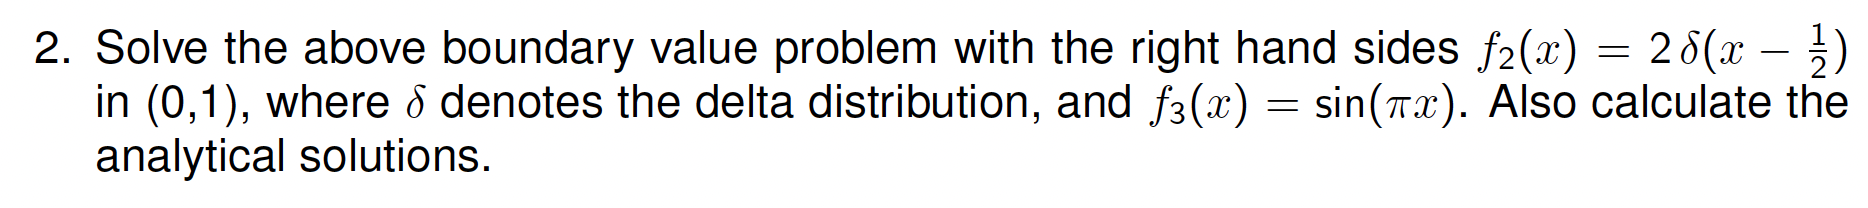

## Case 2: $f(x) = 2\delta(x-1/2)$ (Linear)

For the right-hand side 
$f(x) = 2 \, \delta\Big(x - \frac{1}{2}\Big)$

the exact solution is

\
u(x) =
\begin{cases}
x, & 0 \le x \le \frac{1}{2}, \\[2mm]
1 - x, & \frac{1}{2} \le x \le 1.
\end{cases}


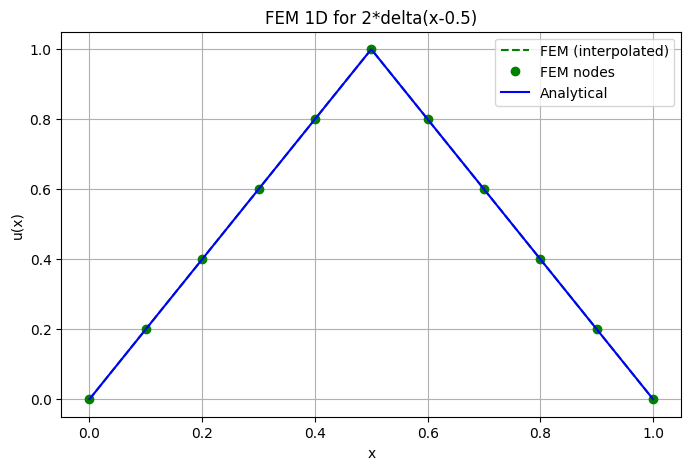

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

## Grid generation
def grid(N, ansatz='linear', nonuniform=False):
    """Generate uniform or non-uniform 1D grid."""
    node_count = N + 1 if ansatz == 'linear' else 3*N - (N - 1)
    ## each element has 2 nodes for linear ansatz. so the total nodes are N+1. Else is for quadratic ansatz (each element has 3 nodes, but the middle nodes are shared))
    vec = np.linspace(0, 1, node_count)
    if nonuniform:
        vec = vec**2  # non-uniform mapping
    return vec

def assembleMatrix(lattice):
    n = len(lattice)
    main = np.zeros(n)
    ## main diagonal
    upper = np.zeros(n-1)
    ## upper diagonal
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h

    return diags([main, upper, upper], [0, -1, 1], format='csc') ## Right-hand side for delta function

def rhsDelta(lattice):
    """RHS vector for delta(x-0.5)."""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        if lattice[i] <= 0.5 <= lattice[i+1]:
            ##Checks if the delta source at x = 0.5 lies inside this element.
            ##Only the element containing x=0.5 gets a non-zero contribution.
            h = lattice[i+1] - lattice[i]
            ##h is the length of the element containing the delta.
            b[i] += 2 * (lattice[i+1] - 0.5)/h
            ##RHS value for the left node of the element.
            b[i+1] += 2 * (0.5 - lattice[i])/h
            ##RHS value for the right node of the element.
    return b

## FEM iplementation for delta function
def FEM1DDelta(N):
    G = grid(N)
    A = assembleMatrix(G)
    b = rhsDelta(G)
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1,1:-1], b[1:-1]) 
    u[1:-1] = u_interior
    u_analytical = np.where(G <= 0.5, 2*G, 2*(1-G))
    #This line defines the analytical solution for the PDE:
    #-u''(x) = 2δ(x - 0.5), u(0) = u(1) = 0
    # G is the vector of FEM nodes (grid points)
    # u_analytical will store the exact solution at each node
    # For x <= 0.5, the solution is u(x) = 2x
    # For x > 0.5, the solution is u(x) = 2(1 - x) 
    # This creates a piecewise linear function peaking at x=0.5
    return G, u, u_analytical

## Interpolation and Plotting
def interpolate(x, lattice, u):
    u_interp = np.zeros_like(x)
    for k, xi in enumerate(x):
        i = np.searchsorted(lattice, xi) - 1
        i = np.clip(i, 0, len(lattice)-2)
        h = lattice[i+1]-lattice[i]
        phi_left = (lattice[i+1]-xi)/h
        phi_right = (xi-lattice[i])/h
        u_interp[k] = phi_left*u[i] + phi_right*u[i+1]
    return u_interp

def plotResult(x, u, X, U):
    u_int = interpolate(X, x, u)
    plt.figure(figsize=(8,5))
    plt.plot(X, u_int, '--g', label='FEM (interpolated)')
    plt.plot(x, u, 'og', label='FEM nodes')
    plt.plot(X, U, '-b', label='Analytical')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('FEM 1D for 2*delta(x-0.5)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Implementation test 
if __name__ == "__main__":
    x, u, u_analytical = FEM1DDelta(10) 
    X = np.linspace(0, 1, 1000)
    U = np.where(X <= 0.5, 2*X, 2*(1-X))       
    plotResult(x, u, X, U)




The FEM solution closely follows the analytical solution.

Small differences might appear if the mesh is coarse (`N = 10`), especially near the delta.

Increasing the number of elements (finer grid) makes FEM converge perfectly to the analytical V-shape.


## Case 3: f(x) = $\sin(\pi x)$ (Linear)

The analytical solution can be obtained by integrating twice:

$$
u(x) = \frac{\sin(\pi x)}{\pi^2}
$$


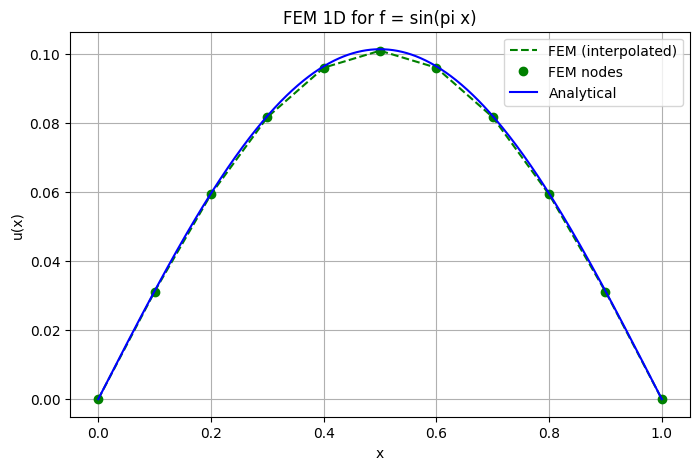

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def grid(N, ansatz='linear', nonuniform=False):
    """Generate uniform or non-uniform 1D grid."""
    node_count = N + 1 if ansatz == 'linear' else 3*N - (N - 1)
    ## each element has 2 nodes for linear ansatz. so the total nodes are N+1. Else is for quadratic ansatz (each element has 3 nodes, but the middle nodes are shared))
    vec = np.linspace(0, 1, node_count)
    if nonuniform:
        vec = vec**2  # non-uniform mapping
    return vec

def assembleMatrix(lattice):
    n = len(lattice)
    main = np.zeros(n)
    upper = np.zeros(n-1)
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h
    return diags([main, upper, upper], [0, -1, 1], format='csc')

def rhsSinPi(lattice):
    """RHS vector for f(x) = sin(pi x)"""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        x_mid = 0.5*(lattice[i]+lattice[i+1])
        f_mid = np.sin(np.pi * x_mid)
        b[i] += f_mid * h/2
        b[i+1] += f_mid * h/2
    return b

def FEM1DSinPi(N):
    G = grid(N)
    A = assembleMatrix(G)
    b = rhsSinPi(G)
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1,1:-1], b[1:-1])
    u[1:-1] = u_interior
    u_analytical = np.sin(np.pi * G)/np.pi**2
    return G, u, u_analytical

def interpolate(x, lattice, u):
    u_interp = np.zeros_like(x)
    for k, xi in enumerate(x):
        i = np.searchsorted(lattice, xi) - 1
        i = np.clip(i, 0, len(lattice)-2)
        h = lattice[i+1]-lattice[i]
        phi_left = (lattice[i+1]-xi)/h
        phi_right = (xi-lattice[i])/h
        u_interp[k] = phi_left*u[i] + phi_right*u[i+1]
    return u_interp

def plotResult(x, u, X, U):
    u_int = interpolate(X, x, u)
    plt.figure(figsize=(8,5))
    plt.plot(X, u_int, '--g', label='FEM (interpolated)')
    plt.plot(x, u, 'og', label='FEM nodes')
    plt.plot(X, U, '-b', label='Analytical')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('FEM 1D for f = sin(pi x)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    x, u, u_analytical = FEM1DSinPi(10) 
    X = np.linspace(0, 1, 1000)
    U = np.sin(np.pi * X)/np.pi**2
    plotResult(x, u, X, U)


The largest discrepancies appear near the middle of the domain, where the curvature of the sine function is highest

### II.3-4> Exercise 3-4 <a name="II.2"></a>

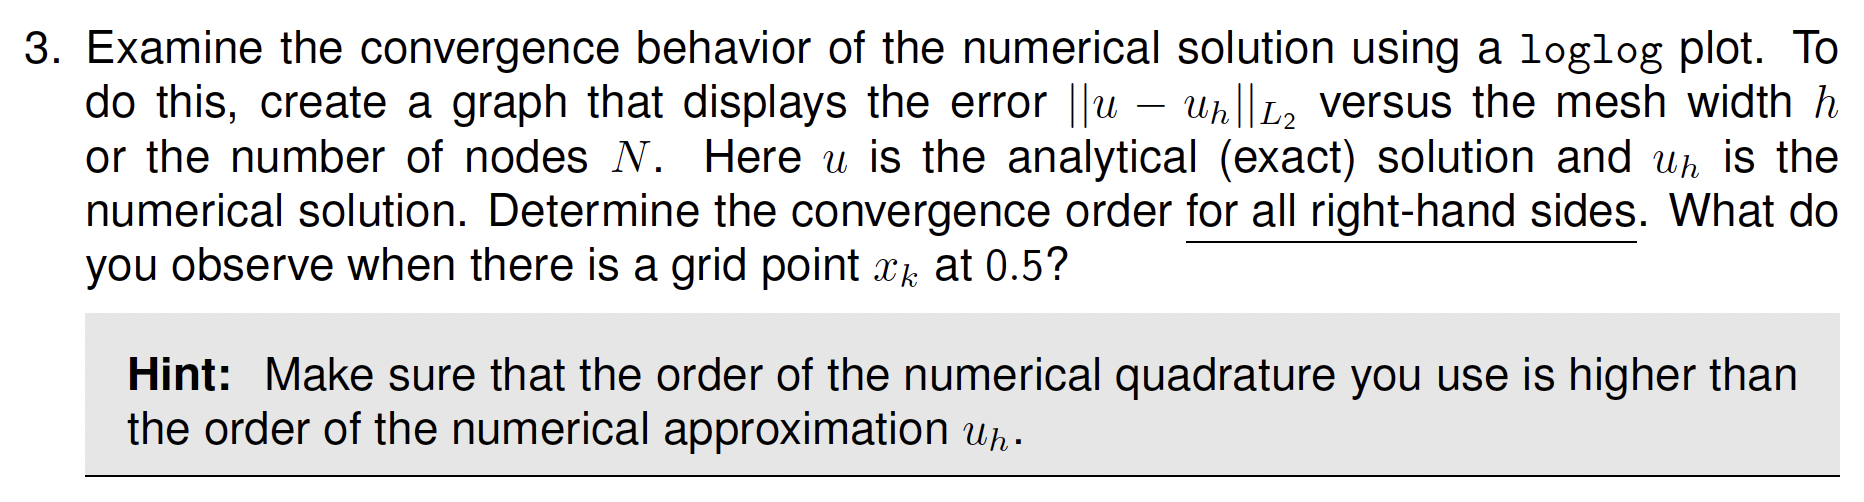

If FEM converges with order p (for linear FEM, p = 2 in L²-norm), then:

$$
\|u - u_h\|_{L^2} \approx C h^p
$$

Taking logarithms on both sides gives:

$$
\log(\|u - u_h\|_{L^2}) = \log(C) + p \log(h)
$$

✅ **The slope of the line on the log–log plot is the convergence order p.**

L¹ Error Computation for FEM Solution

The L¹ error measures the average absolute difference between the FEM solution $u_h(x)$ and the exact solution $u(x)$:

$$
\| u - u_h \|_{L^1} = \int_0^1 |u(x) - u_h(x)| \, dx
$$

In the code, we approximate this integral using the **trapezoidal rule** over a fine grid $x_i$:

$$
L1\_error \approx \sum_{i=0}^{M-1} \frac{x_{i+1} - x_i}{2} \left( |u(x_i) - u_h(x_i)| + |u(x_{i+1}) - u_h(x_{i+1})| \right)
$$




 L² Norm (Root Mean Square Error)

The L² error measures the mean-square difference between the FEM solution $u_h(x)$ and the exact solution $u(x)$:

$$
\| u - u_h \|_{L^2} = \left( \int_0^1 (u(x) - u_h(x))^2 \, dx \right)^{1/2}
$$

In the code, we approximate this integral using the **trapezoidal rule** over a fine grid $x_i$:

$$
L2\_error \approx \sum_{i=0}^{M-1} \frac{x_{i+1} - x_i}{2} \left( (u(x_i) - u_h(x_i))^2 + (u(x_{i+1}) - u_h(x_{i+1}))^2 \right)
$$

The $L^\infty$ error measures the largest pointwise error:

$$
\| u - u_h \|_{L^\infty} = \max_{x \in [0,1]} | u(x) - u_h(x) |
$$

On a fine grid $x_i$, this is computed simply as:

$$
\text{Linf\_error} = \max_i | u(x_i) - u_h(x_i) |
$$


## Case 1: $f = 1$ (linear)

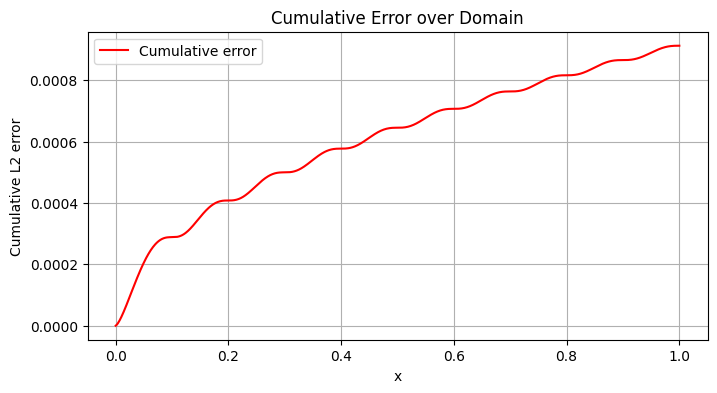

N      L1 Error      L2 Error      Linf Error
  4   2.602e-03   4.032e-03   7.812e-03   - - -
  8   6.504e-04   1.008e-03   1.953e-03   1.9999999999999991 1.9999999999999991 1.9999999999999911
 16   1.626e-04   2.520e-04   4.883e-04   1.9999999999999958 1.999999999999997 2.0000000000000306
 32   4.065e-05   6.301e-05   1.221e-04   1.999999999996227 1.9999999999968543 1.9999999999954485
 64   1.016e-05   1.575e-05   3.052e-05   1.9999999999556275 1.9999999999630196 1.9999999999514515
128   2.541e-06   3.938e-06   7.629e-06   1.9999999998168922 1.9999999998474023 1.9999999998746922


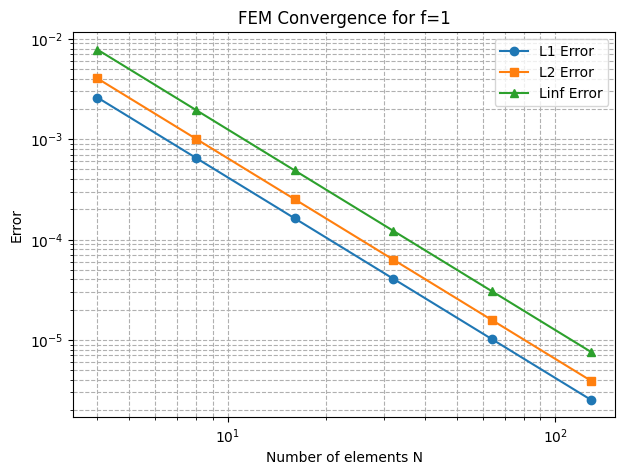

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def u_f(x):
    return -0.5*(x - 0.5)**2 + 1/8

def u_a_ij(i, j, h):
    """Stiffness matrix entry for linear hat functions"""
    if i == j:
        return 2 / h
    elif abs(i - j) == 1:
        return -1 / h
    else:
        return 0

def u_b(i, h):
    """RHS entry for linear hat functions with f=1"""
    return h

def solve_fem(N):
    h = 1 / N
    a = np.array([[u_a_ij(i,j,h) for j in range(1,N)] for i in range(1,N)])
    b = np.array([u_b(i,h) for i in range(1,N)])
    x = np.linalg.solve(a,b)
    # pad with boundary zeros
    u_num = np.pad(x, 1, 'constant', constant_values=0)
    x_grid = np.linspace(0,1,N+1)
    return x_grid, u_num

def interp_fine(x_grid, u_num, fine_x):
    return np.interp(fine_x, x_grid, u_num)

def l1_err(u_exact, u_num):
    return np.trapezoid(np.abs(u_exact - u_num), dx=u_exact[1]-u_exact[0])

def l2_err(u_exact, u_num):
    return np.sqrt(np.trapezoid((u_exact - u_num)**2, dx=u_exact[1]-u_exact[0]))

def linf_err(u_exact, u_num):
    return np.max(np.abs(u_exact - u_num))

if __name__ == "__main__":
    N_plot = 10
    x_grid, u_num = solve_fem(N_plot)
    fine_x = np.linspace(0,1,1000)
    u_exact = u_f(fine_x)
    u_num_fine = interp_fine(x_grid, u_num, fine_x)

    cumulative_error = np.sqrt(np.cumsum((u_exact - u_num_fine)**2) * (fine_x[1]-fine_x[0]))
    plt.figure(figsize=(8,4))
    plt.plot(fine_x, cumulative_error, 'r', label='Cumulative error')
    plt.xlabel('x')
    plt.ylabel('Cumulative L2 error')
    plt.title('Cumulative Error over Domain')
    plt.grid(True)
    plt.legend()
    plt.show()

    Ns = [4,8,16,32,64,128]
    l1_errors, l2_errors, linf_errors = [],[],[]

    for N in Ns:
        x_grid, u_num = solve_fem(N)
        u_num_fine = interp_fine(x_grid, u_num, fine_x)
        u_exact_fine = u_f(fine_x)

        l1_errors.append(l1_err(u_exact_fine, u_num_fine))
        l2_errors.append(l2_err(u_exact_fine, u_num_fine))
        linf_errors.append(linf_err(u_exact_fine, u_num_fine))

    print("N      L1 Error      L2 Error      Linf Error")
    for i,N in enumerate(Ns):
        if i==0:
            rate_l1 = rate_l2 = rate_linf = '-'
        else:
            rate_l1 = np.log(l1_errors[i-1]/l1_errors[i])/np.log(2)
            rate_l2 = np.log(l2_errors[i-1]/l2_errors[i])/np.log(2)
            rate_linf = np.log(linf_errors[i-1]/linf_errors[i])/np.log(2)
        print(f"{N:3d}   {l1_errors[i]:.3e}   {l2_errors[i]:.3e}   {linf_errors[i]:.3e}   "
              f"{rate_l1} {rate_l2} {rate_linf}")

    plt.figure(figsize=(7,5))
    plt.loglog(Ns, l1_errors,'o-', label='L1 Error')
    plt.loglog(Ns, l2_errors,'s-', label='L2 Error')
    plt.loglog(Ns, linf_errors,'^-', label='Linf Error')
    plt.xlabel('Number of elements N')
    plt.ylabel('Error')
    plt.grid(True, which='both', ls='--')
    plt.title('FEM Convergence for f=1')
    plt.legend()
    plt.show()



The slope of the line on the log–log plot is approximately **−2**, which means:

$$
\|u - u_h\|_{L^2} \propto h^2
$$

or equivalently,

$$
\|u - u_h\|_{L^2} \propto N^{-2}
$$

→ This confirms that the **finite element method (FEM) with linear basis functions achieves second-order convergence in the \( L^2 \)-norm.**

---

### Smooth behavior (no irregularities)

Since \( f(x) = 1 \) is smooth and the analytical solution 

$$
-\tfrac{1}{2}(x - \tfrac{1}{2})^2 + \tfrac{1}{8}
= -\tfrac{1}{2}(x^2 - x + \tfrac{1}{4}) + \tfrac{1}{8}
= -\tfrac{1}{2}x^2 + \tfrac{1}{2}x
= \tfrac{1}{2}x(1 - x)
$$


is also smooth, the numerical solution converges regularly — **no oscillations or anomalies** appear in the error curve.


## Case 2: $f(x) = 2\delta(x-1/2)$ (Linear)

For the right-hand side 
$f(x) = 2 \, \delta\Big(x - \frac{1}{2}\Big)$

the exact weak solution is

\
u(x) =
\begin{cases}
x, & 0 \le x \le \frac{1}{2}, \\[2mm]
1 - x, & \frac{1}{2} \le x \le 1.
\end{cases}
\
The slope of the line on the log–log plot is approximately **−1.5** ( guessing..), which means:
$$
\|u - u_h\|_{L^2} \propto h^{1.5}
$$  
or equivalently,
$$
\|u - u_h\|_{L^2} \propto N^{-1.5}
$$  


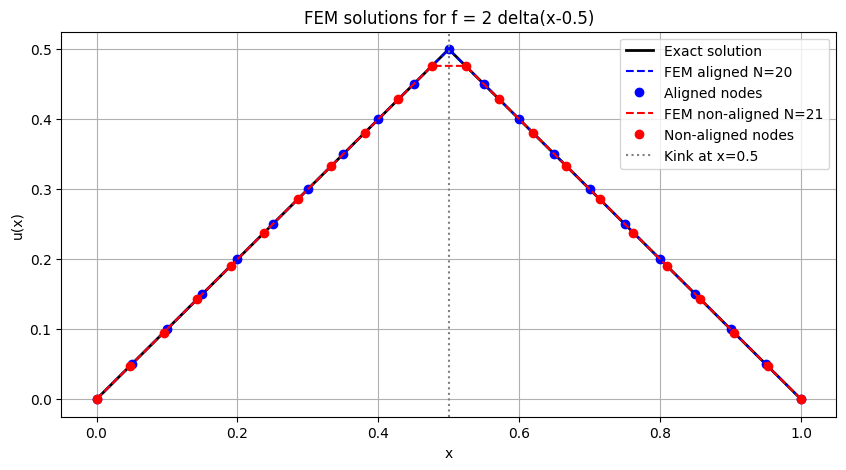

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def grid(N):
    return np.linspace(0, 1, N+1)

def assemble_matrix(lattice):
    n = len(lattice)
    main = np.zeros(n)
    upper = np.zeros(n-1)
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h
    return diags([main, upper, upper], [0, -1, 1], format='csc')

def rhs_delta(lattice):
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        x0, x1 = lattice[i], lattice[i+1]
        if x0 <= 0.5 <= x1:
            h = x1 - x0
            b[i]   += 2*(x1 - 0.5)/h
            b[i+1] += 2*(0.5 - x0)/h
            break
    return b

def FEM1DDelta(N):
    L = grid(N)
    A = assemble_matrix(L)
    b = rhs_delta(L)
    u = np.zeros(len(L))
    if len(L) > 2:
        u[1:-1] = spsolve(A[1:-1,1:-1], b[1:-1])
    return L, u

def u_exact(x):
    return np.where(x <= 0.5, x, 1-x)

N_aligned = 20       # x=0.5 is a node
N_nonaligned = 21    # x=0.5 is inside an element

xfine = np.linspace(0,1,2000)

L_a, u_a = FEM1DDelta(N_aligned)
u_a_fine = np.interp(xfine, L_a, u_a)

L_na, u_na = FEM1DDelta(N_nonaligned)
u_na_fine = np.interp(xfine, L_na, u_na)

u_ex = u_exact(xfine)

plt.figure(figsize=(10,5))

plt.plot(xfine, u_ex, 'k-', label='Exact solution', linewidth=2)

plt.plot(xfine, u_a_fine, 'b--', label=f'FEM aligned N={N_aligned}')
plt.plot(L_a, u_a, 'bo', label='Aligned nodes')

plt.plot(xfine, u_na_fine, 'r--', label=f'FEM non-aligned N={N_nonaligned}')
plt.plot(L_na, u_na, 'ro', label='Non-aligned nodes')

# Highlight kink at x=0.5
plt.axvline(0.5, color='gray', linestyle=':', label='Kink at x=0.5')

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('FEM solutions for f = 2 delta(x-0.5)')
plt.legend()
plt.grid(True)
plt.show()



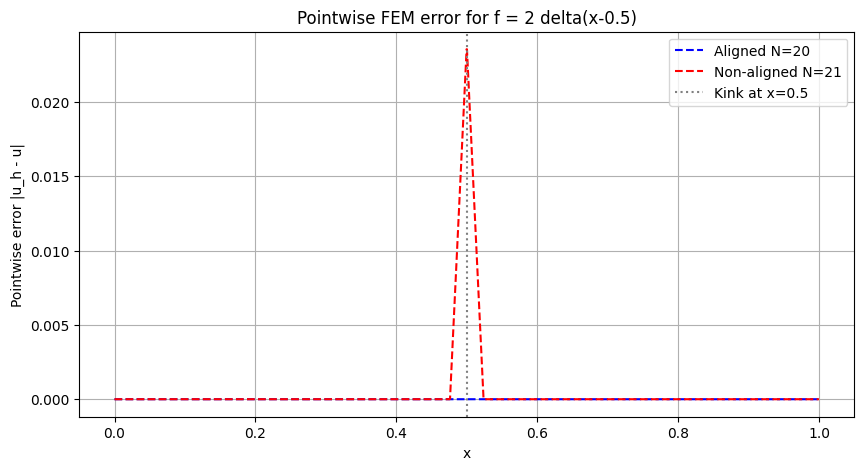

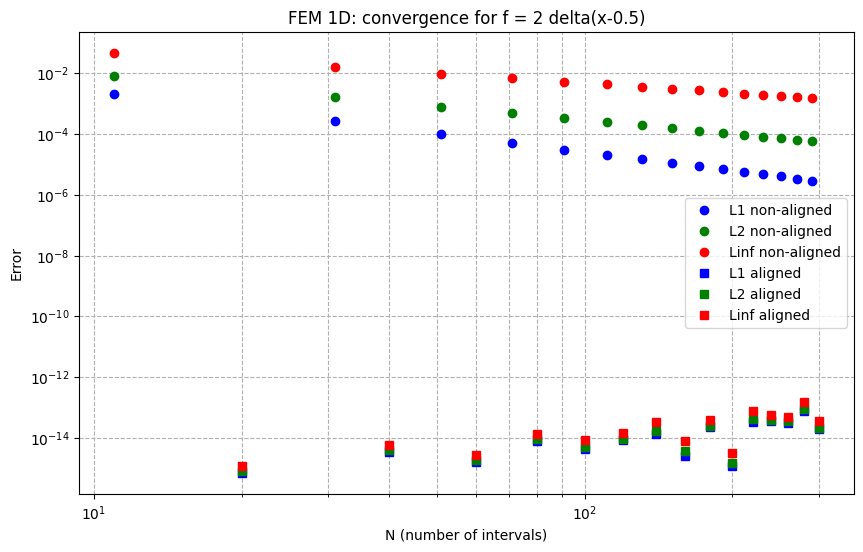

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def grid(N):
    """Uniform grid with N elements -> N+1 nodes"""
    return np.linspace(0, 1, N+1)

def assemble_matrix(lattice):
    """Assemble 1D linear FEM stiffness matrix"""
    n = len(lattice)
    main = np.zeros(n)
    upper = np.zeros(n-1)
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h
    return diags([main, upper, upper], [0, -1, 1], format='csc')

def rhs_delta(lattice):
    """RHS vector for f = 2*delta(x-0.5)"""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        x0, x1 = lattice[i], lattice[i+1]
        if x0 <= 0.5 <= x1:
            h = x1 - x0
            b[i]   += 2*(x1 - 0.5)/h
            b[i+1] += 2*(0.5 - x0)/h
            break
    return b

def FEM1DDelta(N):
    """Solve -u'' = 2*delta(x-0.5) with Dirichlet BCs"""
    L = grid(N)
    A = assemble_matrix(L)
    b = rhs_delta(L)
    u = np.zeros(len(L))
    if len(L) > 2:
        u[1:-1] = spsolve(A[1:-1,1:-1], b[1:-1])
    return L, u

def u_exact(x):
    return np.where(x <= 0.5, x, 1-x)

def interp_on_fine(x_nodes, u_nodes, xfine):
    return np.interp(xfine, x_nodes, u_nodes)

def L1_error(u_num, u_ex, xfine):
    return np.trapezoid(np.abs(u_ex - u_num), xfine)

def L2_error(u_num, u_ex, xfine):
    return np.sqrt(np.trapezoid((u_ex - u_num)**2, xfine))

def Linf_error(u_num, u_ex):
    return np.max(np.abs(u_ex - u_num))

N_aligned = 20       # x=0.5 is a node
N_nonaligned = 21    # x=0.5 is inside an element
xfine = np.linspace(0,1,2000)
u_ex_fine = u_exact(xfine)

L_a, u_a = FEM1DDelta(N_aligned)
u_a_fine = interp_on_fine(L_a, u_a, xfine)

L_na, u_na = FEM1DDelta(N_nonaligned)
u_na_fine = interp_on_fine(L_na, u_na, xfine)

error_aligned = np.abs(u_a_fine - u_ex_fine)
error_nonaligned = np.abs(u_na_fine - u_ex_fine)

plt.figure(figsize=(10,5))
plt.plot(xfine, error_aligned, 'b--', label=f'Aligned N={N_aligned}')
plt.plot(xfine, error_nonaligned, 'r--', label=f'Non-aligned N={N_nonaligned}')
plt.axvline(0.5, color='gray', linestyle=':', label='Kink at x=0.5')
plt.xlabel('x')
plt.ylabel('Pointwise error |u_h - u|')
plt.title('Pointwise FEM error for f = 2 delta(x-0.5)')
plt.grid(True)
plt.legend()
plt.show()

N_values = np.linspace(10, 300, 30, dtype=int)
N_values[::2] += 1  # alternate aligned / non-aligned

errors_L1 = np.zeros(N_values.size)
errors_L2 = np.zeros(N_values.size)
errors_Linf = np.zeros(N_values.size)
h_vals = np.zeros(N_values.size)
aligned_flags = np.zeros(N_values.size, dtype=bool)

for i, n in enumerate(N_values):
    L, u_num = FEM1DDelta(n)
    u_num_fine = interp_on_fine(L, u_num, xfine)
    errors_L1[i] = L1_error(u_num_fine, u_ex_fine, xfine)
    errors_L2[i] = L2_error(u_num_fine, u_ex_fine, xfine)
    errors_Linf[i] = Linf_error(u_num_fine, u_ex_fine)
    h_vals[i] = 1.0/n
    aligned_flags[i] = (0.5 in L)

plt.figure(figsize=(10,6))
for N, e1, e2, einf, aligned in zip(N_values, errors_L1, errors_L2, errors_Linf, aligned_flags):
    if aligned:
        plt.loglog(N, e1, 'bs', label='L1 aligned' if 'L1 aligned' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.loglog(N, e2, 'gs', label='L2 aligned' if 'L2 aligned' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.loglog(N, einf, 'rs', label='Linf aligned' if 'Linf aligned' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.loglog(N, e1, 'bo', label='L1 non-aligned' if 'L1 non-aligned' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.loglog(N, e2, 'go', label='L2 non-aligned' if 'L2 non-aligned' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.loglog(N, einf, 'ro', label='Linf non-aligned' if 'Linf non-aligned' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('N (number of intervals)')
plt.ylabel('Error')
plt.title('FEM 1D: convergence for f = 2 delta(x-0.5)')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()



Suppose $x = 0.5$ falls inside an element, say between nodes $x_i$ and $x_{i+1}$.

- The FEM solution $u_h(x)$ is **linear between $x_i$ and $x_{i+1}$**.
- But the true solution has a **kink inside that element**.
- FEM **cannot capture the exact change in slope**.
- The **error is largest near the kink**.

1. **Error is not uniform**: large near the kink, small elsewhere.
2. This causes the **oscillating behavior of the error** in the log–log plot.
3. The **convergence rate is slower**, because the derivative jump violates the smoothness assumption needed for optimal FEM convergence.


Suppose the domain is $[0,1]$ and the elements are uniform:

$x_0 = 0$, $x_1 = h$, $x_2 = 2h$, $\dots$, $x_N = 1$, with $h = \frac{1}{N}$.

To have a node at $x = 0.5$, we need:

$$
0.5 = i \cdot h \quad \Rightarrow \quad i = \frac{0.5}{h} = 0.5 \, N
$$

Since $i$ must be an integer, **$N$ must be even**.


Assume that $error ≈ C⋅h^k$, then $log(error)=logC+klogh$. The slope of the log(error)-log(h) plot is k, i.e. the order of the numerical method. In the above plot, we can observe that in $f=constant$ case, the convergence order is linear, whereas in the case of delta function, it cannot guarantee to converge as the mesh size is getting smaller(more elements). In fact, we can observe that its numerical solution can be precisely approximated when there is a grid point $x_k$ at 0.5 (even number of elements). Therefore, from our above experiments (switching even and odd number of elements), the graph shows that the errors in the delta function case are oscillating and the errors converge (superlinearly) only when the number of elements is even. 

## Case 3: f(x) = $\sin(\pi x)$ (Linear)

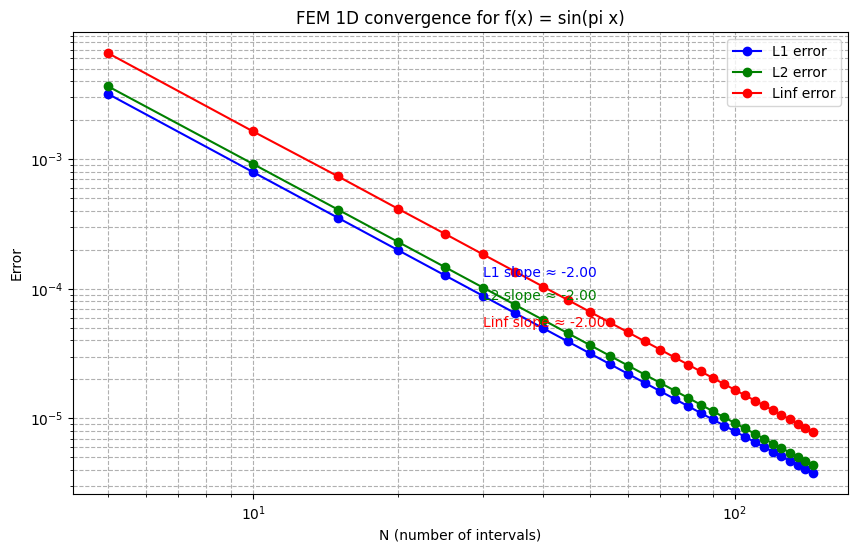

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def grid(N):
    return np.linspace(0, 1, N+1)

def assemble_matrix(lattice):
    n = len(lattice)
    main = np.zeros(n)
    upper = np.zeros(n-1)
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h
    return diags([main, upper, upper], [0, -1, 1], format='csc')

def rhs_sin(lattice):
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        x0, x1 = lattice[i], lattice[i+1]
        h = x1 - x0
        xm = 0.5*(x0 + x1)
        fval = np.sin(np.pi*xm)
        b[i]   += fval*h/2
        b[i+1] += fval*h/2
    return b

def FEM1DSin(N):
    L = grid(N)
    A = assemble_matrix(L)
    b = rhs_sin(L)
    u = np.zeros(len(L))
    if len(L) > 2:
        u[1:-1] = spsolve(A[1:-1,1:-1], b[1:-1])
    return L, u

def u_exact(x):
    return np.sin(np.pi*x)/np.pi**2

def interp_on_fine(x_nodes, u_nodes, xfine):
    return np.interp(xfine, x_nodes, u_nodes)

def L1_error(u_num, u_ex, xfine):
    return np.trapezoid(np.abs(u_ex - u_num), xfine)

def L2_error(u_num, u_ex, xfine):
    return np.sqrt(np.trapezoid((u_ex - u_num)**2, xfine))

def Linf_error(u_num, u_ex):
    return np.max(np.abs(u_ex - u_num))

N = 20
xfine = np.linspace(0,1,2000)
u_ex_fine = u_exact(xfine)

L, u_num = FEM1DSin(N)
u_num_fine = interp_on_fine(L, u_num, xfine)

N_values = np.arange(5, 150, 5)
h_vals = 1/N_values
errors_L1 = np.zeros(N_values.size)
errors_L2 = np.zeros(N_values.size)
errors_Linf = np.zeros(N_values.size)

for i, n in enumerate(N_values):
    L, u_num = FEM1DSin(n)
    u_num_fine = interp_on_fine(L, u_num, xfine)
    errors_L1[i] = L1_error(u_num_fine, u_ex_fine, xfine)
    errors_L2[i] = L2_error(u_num_fine, u_ex_fine, xfine)
    errors_Linf[i] = Linf_error(u_num_fine, u_ex_fine)

plt.figure(figsize=(10,6))
plt.loglog(N_values, errors_L1, 'bo-', label='L1 error')
plt.loglog(N_values, errors_L2, 'go-', label='L2 error')
plt.loglog(N_values, errors_Linf, 'ro-', label='Linf error')

plt.xlabel('N (number of intervals)')
plt.ylabel('Error')
plt.title('FEM 1D convergence for f(x) = sin(pi x)')
plt.grid(True, which='both', ls='--')
slope_L1, _ = np.polyfit(np.log(N_values), np.log(errors_L1), 1)
slope_L2, _ = np.polyfit(np.log(N_values), np.log(errors_L2), 1)
slope_Linf, _ = np.polyfit(np.log(N_values), np.log(errors_Linf), 1)

plt.text(N_values[5], errors_L2[5]*1.2, f"L1 slope ≈ {slope_L1:.2f}", color='blue')
plt.text(N_values[5], errors_L2[5]*0.8, f"L2 slope ≈ {slope_L2:.2f}", color='green')
plt.text(N_values[5], errors_L2[5]*0.5, f"Linf slope ≈ {slope_Linf:.2f}", color='red')

plt.legend()
plt.show()



All three errors ($L^1$, $L^2$, $L^\infty$) **decrease as the mesh gets finer** (smaller $h$).

The plot is approximately a **straight line in log–log scale**

$$
\text{error} \sim C \cdot h^k
$$
The slopes of the lines indicate the convergence rates:
- **$L^1$ error slope:** approximately **−2** → $k \approx 2$  
- **$L^2$ error slope:** approximately **−2** → $k \approx 2$  
- **$L^\infty$ error slope:** approximately **−2** → $k \approx 2$  

### II.5> Bonus Exercise 5 <a name="II.2"></a>

Quadratic basis functions are defined using three nodes per element.
$$
\phi_i^{edge}(x) = 
\begin{cases}
 \frac{(x_{i-2}-x)(x_{i-1}-x)}{(x_{i-2}-x_{i})(x_{i-1}-x_{i})} & \text{for } x \in (x_{i-2}, x_{i-1}] \\
 \frac{(x-x_{i+1})(x-x_{i+1})}{(x_{i}-x_{i+1})(x_{i}-x_{i+2})} & \text{for } x \in (x_{i}, x_{i+2}] \\
 0 & \text{elsewhere}
\end{cases}
$$ 

$$
\phi_j^{inner}(x) = 
\begin{cases}
 \frac{(x-x_{j-1})(x_{j+1}-x)}{(x_{j}-x_{j-1})(x_{j+1}-x_{j})} & \text{for } x \in (x_{j-1}, x_{j+1}] \\
 0 & \text{elsewhere}
\end{cases}
$$


## Case 1: $f = 1$ (quadratic)

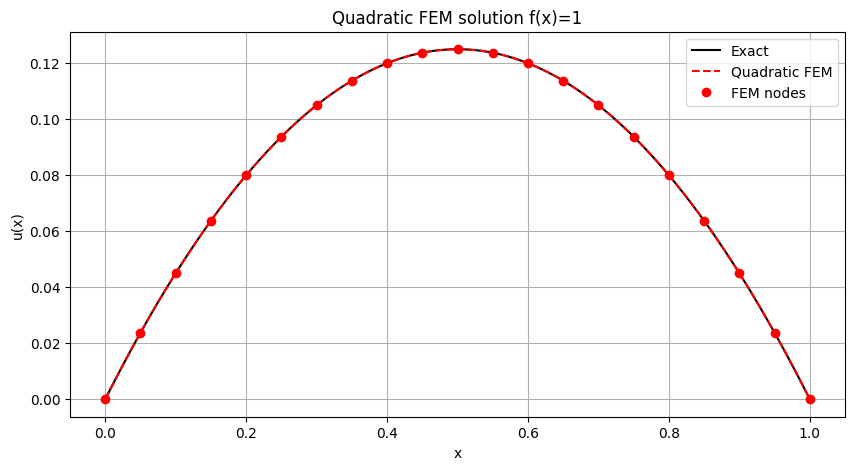

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_quadratic(N):
    nodes = np.linspace(0,1,N+1) #creates the vertex nodes of a uniform partition of [0,1] into N elements 
    #There are N+1 vertices indexed 0..N

    mid_nodes = (nodes[:-1]+nodes[1:])/2 #creates the midpoint nodes for each element (one midpoint per element). 
    # nodes[:-1] and nodes[1:] pair neighboring vertices
    all_nodes = np.sort(np.concatenate([nodes,mid_nodes])) # merges vertex and midpoint arrays and sorts them
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n,n))
    for i in range(0,n-2,2):
        h = L[i+2]-L[i]
        Ke = (1/h)*np.array([[7,-8,1],[-8,16,-8],[1,-8,7]])/3.0
        K[i:i+3,i:i+3] += Ke
    return K.tocsc()

def rhs_quadratic(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0,n-2,2):
        h = L[i+2]-L[i]
        b[i:i+3] += h/6*np.array([1,4,1]) 
    return b

def FEM1DQuadratic(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_quadratic(L)
    u = np.zeros(len(L))
    free = np.arange(1,len(L)-1)
    u[free] = spsolve(K[free,:][:,free],b[free])
    u_exact = -0.5*(L-0.5)**2 + 1/8
    return L,u,u_exact

def interpolate_quadratic(L,u,Lfine):
    u_fine = np.zeros_like(Lfine)
    for i in range(0,len(L)-2,2):
        x0,x1,x2 = L[i],L[i+1],L[i+2]
        u0,u1,u2 = u[i],u[i+1],u[i+2]
        mask = (Lfine>=x0) & (Lfine<=x2)
        xi = (Lfine[mask]-x0)/(x2-x0)
        phi0 = 2*(xi-0.5)*(xi-1)
        phi1 = 4*xi*(1-xi)
        phi2 = 2*xi*(xi-0.5)
        u_fine[mask] = u0*phi0 + u1*phi1 + u2*phi2
    return u_fine


if __name__=="__main__":
    N = 10
    L,u_num,u_exact = FEM1DQuadratic(N)
    Lfine = np.linspace(0, 1, 5000) 
    u_num_fine = interpolate_quadratic(L, u_num, Lfine)
    u_exact_fine = -0.5*(Lfine-0.5)**2 + 1/8

    plt.figure(figsize=(10,5))
    plt.plot(Lfine,u_exact_fine,'k-',label='Exact')
    plt.plot(Lfine,u_num_fine,'r--',label='Quadratic FEM')
    plt.plot(L,u_num,'ro',label='FEM nodes')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Quadratic FEM solution f(x)=1')
    plt.grid(True)
    plt.legend()
    plt.show()



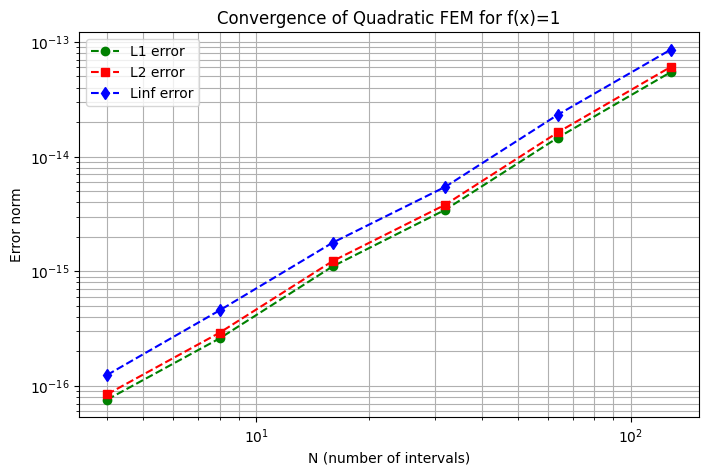

Convergence orders (based on N):
L1:   [-1.77679386 -2.08075203 -1.64138032 -2.09095784 -1.8948372 ]  avg ≈ -1.90
L2:   [-1.78819572 -2.06851661 -1.63499866 -2.09750344 -1.89199485]  avg ≈ -1.90
Linf: [-1.87446912 -1.95560588 -1.6183855  -2.09155988 -1.8813432 ]  avg ≈ -1.88


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_quadratic(N):
    nodes = np.linspace(0, 1, N + 1)
    mid_nodes = (nodes[:-1] + nodes[1:]) / 2
    all_nodes = np.sort(np.concatenate([nodes, mid_nodes]))
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n, n))
    for i in range(0, n - 2, 2):
        h = L[i + 2] - L[i]
        Ke = (1 / h) * np.array([[7, -8, 1],
                                 [-8, 16, -8],
                                 [1, -8, 7]]) / 3.0
        K[i:i + 3, i:i + 3] += Ke
    return K.tocsc()

def rhs_quadratic(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0, n - 2, 2):
        h = L[i + 2] - L[i]
        b[i:i + 3] += h / 6 * np.array([1, 4, 1])
    return b

def FEM1DQuadratic(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_quadratic(L)
    u = np.zeros(len(L))
    free = np.arange(1, len(L) - 1)
    u[free] = spsolve(K[free, :][:, free], b[free])
    u_exact = -0.5 * (L - 0.5) ** 2 + 1 / 8
    return L, u, u_exact

# Error norms (L1, L2, Linf) 
def error_norms(L, u, u_exact):
    err_L1 = 0.0
    err_L2 = 0.0
    err_Linf = 0.0

    for i in range(0, len(L) - 2, 2):
        x0, x1, x2 = L[i], L[i + 1], L[i + 2]
        uh0, uh1, uh2 = u[i], u[i + 1], u[i + 2]
        h = x2 - x0
        gp = np.array([-np.sqrt(3 / 5), 0, np.sqrt(3 / 5)])
        w = np.array([5 / 9, 8 / 9, 5 / 9])
        for xi, wi in zip(gp, w):
            x = (x0 + x2) / 2 + xi * h / 2
            phi0 = 0.5 * xi * (xi - 1)
            phi1 = (1 - xi ** 2)
            phi2 = 0.5 * xi * (xi + 1)
            uh = uh0 * phi0 + uh1 * phi1 + uh2 * phi2
            ue = -0.5 * (x - 0.5) ** 2 + 1 / 8
            diff = abs(ue - uh)
            err_L1 += wi * diff * (h / 2)
            err_L2 += wi * diff**2 * (h / 2)
            err_Linf = max(err_Linf, diff)
    return err_L1, np.sqrt(err_L2), err_Linf

Ns = [4, 8, 16, 32, 64, 128]
errors_L1, errors_L2, errors_Linf = [], [], []
hs = []

for N in Ns:
    L, u, u_exact = FEM1DQuadratic(N)
    e1, e2, einf = error_norms(L, u, u_exact)
    errors_L1.append(e1)
    errors_L2.append(e2)
    errors_Linf.append(einf)
    hs.append(1 / N)

errors_L1 = np.array(errors_L1)
errors_L2 = np.array(errors_L2)
errors_Linf = np.array(errors_Linf)
hs = np.array(hs)

plt.figure(figsize=(8, 5))
plt.loglog(Ns, errors_L1, 'o--g', label='L1 error')
plt.loglog(Ns, errors_L2, 's--r', label='L2 error')
plt.loglog(Ns, errors_Linf, 'd--b', label='Linf error')
plt.xlabel('N (number of intervals)')
plt.ylabel('Error norm')
plt.title('Convergence of Quadratic FEM for f(x)=1')
plt.grid(True, which='both')
plt.legend()
plt.show()

def convergence_rate_N(errors, Ns):
    return np.log(errors[:-1] / errors[1:]) / np.log(np.array(Ns[1:]) / np.array(Ns[:-1]))

rate_L1 = convergence_rate_N(errors_L1, Ns)
rate_L2 = convergence_rate_N(errors_L2, Ns)
rate_Linf = convergence_rate_N(errors_Linf, Ns)

print("Convergence orders (based on N):")
print(f"L1:   {rate_L1}  avg ≈ {np.mean(rate_L1):.2f}")
print(f"L2:   {rate_L2}  avg ≈ {np.mean(rate_L2):.2f}")
print(f"Linf: {rate_Linf}  avg ≈ {np.mean(rate_Linf):.2f}")




## Case 2: $f(x) = 2\delta(x-1/2)$ (Quadratic)

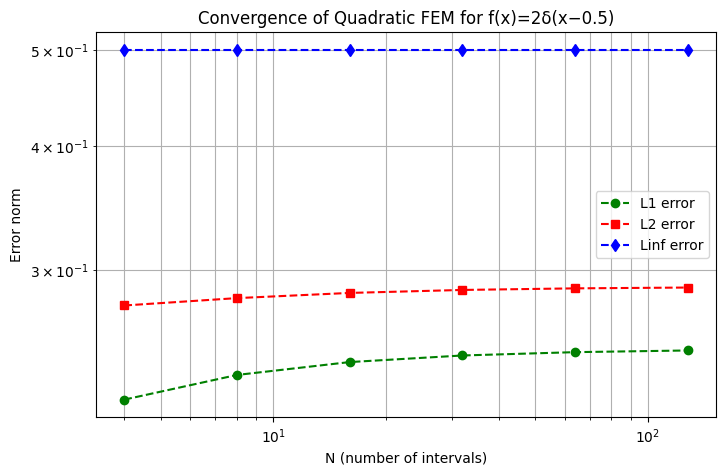

Convergence rates (based on N):
L1:   [-0.08246216 -0.04306872 -0.02202631 -0.01114056 -0.00560271]  avg ≈ -0.03
L2:   [-0.02464765 -0.01732824 -0.00995778 -0.00530619 -0.00273532]  avg ≈ -0.01
Linf: [6.08651036e-15 2.69087826e-14 6.82329845e-14 3.32515671e-13
 1.15899971e-12]  avg ≈ 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_quadratic(N):
    nodes = np.linspace(0, 1, N + 1)
    mid_nodes = (nodes[:-1] + nodes[1:]) / 2
    all_nodes = np.sort(np.concatenate([nodes, mid_nodes]))
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n, n))
    for i in range(0, n - 2, 2):
        h = L[i + 2] - L[i]
        Ke = (1 / h) * np.array([[7, -8, 1],
                                 [-8, 16, -8],
                                 [1, -8, 7]]) / 3.0
        K[i:i + 3, i:i + 3] += Ke
    return K.tocsc()

def rhs_delta_quadratic(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0, n - 2, 2):
        x0, x1, x2 = L[i], L[i + 1], L[i + 2]
        if x0 <= 0.5 <= x2:
            h = x2 - x0
            xi = 2 * (0.5 - (x0 + x2) / 2) / h
            # Quadratic shape functions at xi
            phi0 = 0.5 * xi * (xi - 1)
            phi1 = (1 - xi**2)
            phi2 = 0.5 * xi * (xi + 1)
            b[i:i + 3] += 2 * np.array([phi0, phi1, phi2])
    return b

def FEM1DQuadratic_delta(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_delta_quadratic(L)
    u = np.zeros(len(L))
    free = np.arange(1, len(L) - 1)
    u[free] = spsolve(K[free, :][:, free], b[free])
    # Analytical piecewise solution for -u'' = 2δ(x-0.5)
    u_exact = np.where(L <= 0.5, L, 1 - L)
    return L, u, u_exact

def error_norms(L, u, u_exact):
    err_L1 = np.sum(np.abs(u - u_exact)) * (1 / len(L))
    err_L2 = np.sqrt(np.sum((u - u_exact) ** 2) * (1 / len(L)))
    err_Linf = np.max(np.abs(u - u_exact))
    return err_L1, err_L2, err_Linf

Ns = [4, 8, 16, 32, 64, 128] # loop does each N one by one 
errors_L1, errors_L2, errors_Linf = [], [], []
hs = []

for N in Ns:
    L, u, u_exact = FEM1DQuadratic_delta(N)
    e1, e2, einf = error_norms(L, u, u_exact)
    errors_L1.append(e1)
    errors_L2.append(e2)
    errors_Linf.append(einf)
    hs.append(1 / N)

errors_L1 = np.array(errors_L1)
errors_L2 = np.array(errors_L2)
errors_Linf = np.array(errors_Linf)
hs = np.array(hs)

plt.figure(figsize=(8, 5))
plt.loglog(Ns, errors_L1, 'o--g', label='L1 error')
plt.loglog(Ns, errors_L2, 's--r', label='L2 error')
plt.loglog(Ns, errors_Linf, 'd--b', label='Linf error')
plt.xlabel('N (number of intervals)')
plt.ylabel('Error norm')
plt.title('Convergence of Quadratic FEM for f(x)=2δ(x−0.5)')
plt.grid(True, which='both')
plt.legend()
plt.show()

def convergence_rate_N(errors, Ns):
    return np.log(errors[:-1] / errors[1:]) / np.log(np.array(Ns[1:]) / np.array(Ns[:-1]))

rate_L1 = convergence_rate_N(errors_L1, Ns)
rate_L2 = convergence_rate_N(errors_L2, Ns)
rate_Linf = convergence_rate_N(errors_Linf, Ns)

print("Convergence rates (based on N):")
print(f"L1:   {rate_L1}  avg ≈ {np.mean(rate_L1):.2f}")
print(f"L2:   {rate_L2}  avg ≈ {np.mean(rate_L2):.2f}")
print(f"Linf: {rate_Linf}  avg ≈ {np.mean(rate_Linf):.2f}")


For the case

$$
f(x) = 2 \, \delta(x - 0.5),
$$

the quadratic FEM does not exhibit clear convergence in any norm ($L^1$, $L^2$, or $L^\infty$). The computed rates are approximately zero, reflecting the fact that the exact solution has a non-smooth derivative at

$$
x = 0.5.
$$

Because of this singularity, higher-order elements cannot improve accuracy, and the error remains nearly constant with mesh refinement.


## Case 3: f(x) = $\sin(\pi x)$ (Quadratic)

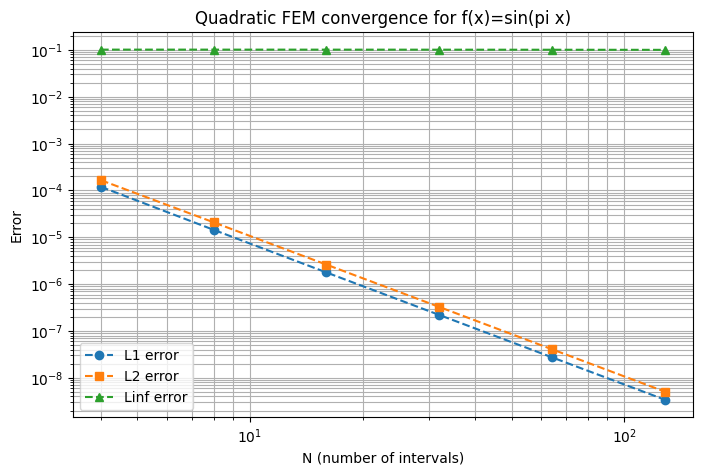

Convergence rates (based on N):
L1: [3.04958644 3.02153213 3.009956   3.00477476 3.00232876] avg ≈ 3.017635618194673
L2: [2.98981797 2.99744729 2.99936138 2.99984031 2.99995999] avg ≈ 2.99728538666511
Linf: [0.00058373 0.00115657 0.00231443 0.00434691 0.00726947] avg ≈ 0.003134222251275802


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_quadratic(N):
    nodes = np.linspace(0, 1, N + 1)
    mid_nodes = (nodes[:-1] + nodes[1:]) / 2
    all_nodes = np.sort(np.concatenate([nodes, mid_nodes]))
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n, n))
    for i in range(0, n - 2, 2):
        h = L[i + 2] - L[i]
        Ke = (1 / h) * np.array([[7, -8, 1],
                                 [-8, 16, -8],
                                 [1, -8, 7]]) / 3.0
        K[i:i + 3, i:i + 3] += Ke
    return K.tocsc()

def rhs_quadratic_sin(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0, n - 2, 2):
        x0, x1, x2 = L[i], L[i+1], L[i+2]
        h = x2 - x0
        gp = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        w = np.array([5/9, 8/9, 5/9])
        for xi, wi in zip(gp, w):
            x = (x0 + x2)/2 + xi*h/2
            phi0 = 0.5*xi*(xi-1)
            phi1 = 1 - xi**2
            phi2 = 0.5*xi*(xi+1)
            b[i]   += wi*phi0*np.sin(np.pi*x)*h/2
            b[i+1] += wi*phi1*np.sin(np.pi*x)*h/2
            b[i+2] += wi*phi2*np.sin(np.pi*x)*h/2
    return b

def FEM1DQuadratic_sin(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_quadratic_sin(L)
    u = np.zeros(len(L))
    free = np.arange(1, len(L)-1)
    u[free] = spsolve(K[free,:][:,free], b[free])
    u_exact = np.sin(np.pi*L)/np.pi**2
    return L, u, u_exact

def L1_error(L, u, u_exact):
    err = 0.0
    for i in range(0,len(L)-2,2):
        x0,x1,x2 = L[i], L[i+1], L[i+2]
        h = x2-x0
        gp = np.array([-np.sqrt(3/5),0,np.sqrt(3/5)])
        w = np.array([5/9,8/9,5/9])
        for xi, wi in zip(gp,w):
            x = (x0+x2)/2 + xi*h/2
            phi0 = 0.5*xi*(xi-1)
            phi1 = 1-xi**2
            phi2 = 0.5*xi*(xi+1)
            uh = u[i]*phi0 + u[i+1]*phi1 + u[i+2]*phi2
            ue = np.sin(np.pi*x)/np.pi**2
            err += wi*np.abs(ue-uh)*h/2
    return err

def L2_error(L, u, u_exact):
    err = 0.0
    for i in range(0,len(L)-2,2):
        x0,x1,x2 = L[i], L[i+1], L[i+2]
        h = x2-x0
        gp = np.array([-np.sqrt(3/5),0,np.sqrt(3/5)])
        w = np.array([5/9,8/9,5/9])
        for xi, wi in zip(gp,w):
            x = (x0+x2)/2 + xi*h/2
            phi0 = 0.5*xi*(xi-1)
            phi1 = 1-xi**2
            phi2 = 0.5*xi*(xi+1)
            uh = u[i]*phi0 + u[i+1]*phi1 + u[i+2]*phi2
            ue = np.sin(np.pi*x)/np.pi**2
            err += wi*(ue-uh)**2*h/2
    return np.sqrt(err)

def Linf_error(L, u, u_exact):
    u_fine = np.linspace(0,1,5000)
    u_exact_fine = np.sin(np.pi*u_fine)/np.pi**2
    # quadratic interpolation
    u_num_fine = np.zeros_like(u_fine)
    for i in range(0,len(L)-2,2):
        x0,x1,x2 = L[i],L[i+1],L[i+2]
        uh0,uh1,uh2 = u[i],u[i+1],u[i+2]
        mask = (u_fine>=x0)&(u_fine<=x2)
        xi = (u_fine[mask]-x0)/(x2-x0)
        phi0 = xi*(xi-1)/0.5
        phi1 = 1-(2*xi-1)**2
        phi2 = xi*(xi-0.5)/0.5
        u_num_fine[mask] = uh0*phi0 + uh1*phi1 + uh2*phi2
    return np.max(np.abs(u_num_fine - u_exact_fine))

Ns = [4,8,16,32,64,128]
L1_err,L2_err,Linf_err = [],[],[]

for N in Ns:
    L,u,u_exact = FEM1DQuadratic_sin(N)
    L1_err.append(L1_error(L,u,u_exact))
    L2_err.append(L2_error(L,u,u_exact))
    Linf_err.append(Linf_error(L,u,u_exact))

h_vals = np.array(h_vals)
L1_err = np.array(L1_err)
L2_err = np.array(L2_err)
Linf_err = np.array(Linf_err)

plt.figure(figsize=(8,5))
plt.loglog(Ns, L1_err,'o--',label='L1 error')
plt.loglog(Ns, L2_err,'s--',label='L2 error')
plt.loglog(Ns, Linf_err,'^--',label='Linf error')
plt.xlabel('N (number of intervals)')
plt.ylabel('Error')
plt.title('Quadratic FEM convergence for f(x)=sin(pi x)')
plt.grid(True,which='both')
plt.legend()
plt.show()

rate_L1 = np.log(L1_err[:-1]/L1_err[1:])/np.log(np.array(Ns[1:])/np.array(Ns[:-1]))
rate_L2 = np.log(L2_err[:-1]/L2_err[1:])/np.log(np.array(Ns[1:])/np.array(Ns[:-1]))
rate_Linf = np.log(Linf_err[:-1]/Linf_err[1:])/np.log(np.array(Ns[1:])/np.array(Ns[:-1]))

print("Convergence rates (based on N):")
print("L1:", rate_L1, "avg ≈", np.mean(rate_L1))
print("L2:", rate_L2, "avg ≈", np.mean(rate_L2))
print("Linf:", rate_Linf, "avg ≈", np.mean(rate_Linf))




Larger \(convergence rate\) → steeper slope → error decreases faster as you refine the mesh.  

Smaller \(convergence rate\) → shallower slope → error decreases more slowly with refinement.

L1 and L2 errors converge slightly faster than Linf error

## Error Comparison Between Linear and Quadratic FEM

#### For constant case function

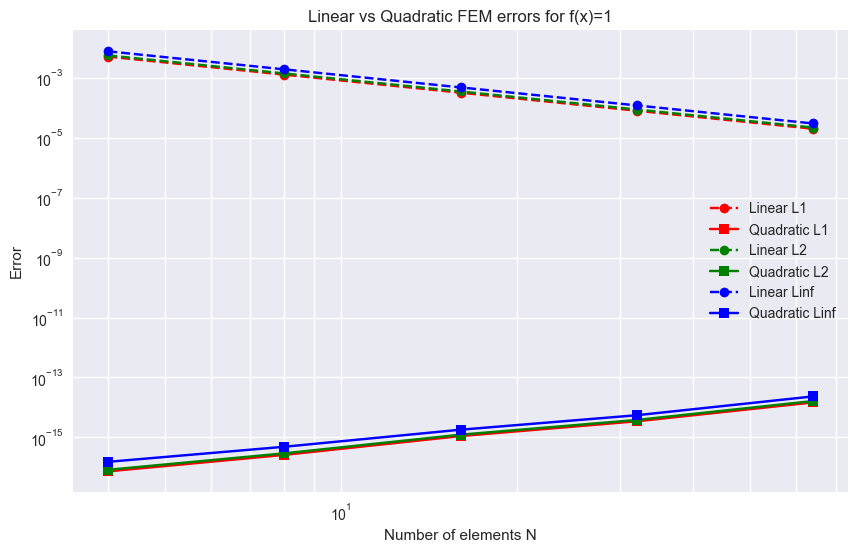

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_linear(N):
    return np.linspace(0, 1, N+1)

def assemble_matrix_linear(L):
    n = len(L)
    K = lil_matrix((n, n))
    for i in range(n-1):
        h = L[i+1]-L[i]
        K[i:i+2, i:i+2] += np.array([[1,-1],[-1,1]])/h
    return K.tocsc()

def rhs_linear(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(n-1):
        h = L[i+1]-L[i]
        b[i:i+2] += h/2
    return b

def FEM1DLinear(N):
    L = grid_linear(N)
    K = assemble_matrix_linear(L)
    b = rhs_linear(L)
    u = np.zeros(len(L))
    free = np.arange(1,len(L)-1)
    u[free] = spsolve(K[free,:][:,free], b[free])
    u_exact = -0.5*(L-0.5)**2 + 1/8
    return L, u, u_exact

def grid_quadratic(N):
    nodes = np.linspace(0,1,N+1)
    mid_nodes = (nodes[:-1]+nodes[1:])/2
    all_nodes = np.sort(np.concatenate([nodes, mid_nodes]))
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n,n))
    for i in range(0,n-2,2):
        h = L[i+2]-L[i]
        Ke = (1/h)*np.array([[7,-8,1],
                             [-8,16,-8],
                             [1,-8,7]])/3.0
        K[i:i+3,i:i+3] += Ke
    return K.tocsc()

def rhs_quadratic(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0,n-2,2):
        h = L[i+2]-L[i]
        b[i:i+3] += h/6*np.array([1,4,1])
    return b

def FEM1DQuadratic(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_quadratic(L)
    u = np.zeros(len(L))
    free = np.arange(1,len(L)-1)
    u[free] = spsolve(K[free,:][:,free],b[free])
    u_exact = -0.5*(L-0.5)**2 + 1/8
    return L, u, u_exact

def quadratic_interpolate(x0,x1,x2,u0,u1,u2,X):
    """Quadratic shape function interpolation over [-1,1] element."""
    h = x2 - x0
    xi = 2*(X - x0)/h - 1  # map to [-1,1]
    phi0 = xi*(xi-1)/2
    phi1 = 1 - xi**2
    phi2 = xi*(xi+1)/2
    return u0*phi0 + u1*phi1 + u2*phi2

def L1_error(X, U, Uexact):
    dx = X[1]-X[0]
    return np.sum(np.abs(U-Uexact))*dx

def L2_error(X, U, Uexact):
    dx = X[1]-X[0]
    return np.sqrt(np.sum((U-Uexact)**2)*dx)

def Linf_error(U, Uexact):
    return np.max(np.abs(U-Uexact))

Ns = [4,8,16,32,64]
errors_linear = {'L1':[],'L2':[],'Linf':[]}
errors_quad   = {'L1':[],'L2':[],'Linf':[]}

Xfine = np.linspace(0,1,5000)
Uexact_fine = -0.5*(Xfine-0.5)**2 + 1/8

for N in Ns:
    # Linear FEM
    L,u,u_exact = FEM1DLinear(N)
    Ufine_linear = np.interp(Xfine, L, u)
    errors_linear['L1'].append(L1_error(Xfine,Ufine_linear,Uexact_fine))
    errors_linear['L2'].append(L2_error(Xfine,Ufine_linear,Uexact_fine))
    errors_linear['Linf'].append(Linf_error(Ufine_linear,Uexact_fine))
    
    # Quadratic FEM
    L,u,u_exact = FEM1DQuadratic(N)
    Ufine_quad = np.zeros_like(Xfine)
    for i in range(0,len(L)-2,2):
        mask = (Xfine >= L[i]) & (Xfine <= L[i+2])
        Ufine_quad[mask] = quadratic_interpolate(L[i],L[i+1],L[i+2],
                                                 u[i],u[i+1],u[i+2],
                                                 Xfine[mask])
    errors_quad['L1'].append(L1_error(Xfine,Ufine_quad,Uexact_fine))
    errors_quad['L2'].append(L2_error(Xfine,Ufine_quad,Uexact_fine))
    errors_quad['Linf'].append(Linf_error(Ufine_quad,Uexact_fine))

plt.figure(figsize=(10,6))
for key,color in zip(['L1','L2','Linf'],['r','g','b']):
    plt.loglog(Ns, errors_linear[key],'o--',color=color,label=f'Linear {key}')
    plt.loglog(Ns, errors_quad[key],'s-',color=color,label=f'Quadratic {key}')

plt.xlabel('Number of elements N')
plt.ylabel('Error')
plt.title('Linear vs Quadratic FEM errors for f(x)=1')
plt.grid(True, which='both')
plt.legend()
plt.show()



**Quadratic FEM is more accurate:**  

For the same number of elements $N$, the errors ($L^1$, $L^2$, $L^\infty$) in the quadratic FEM are much smaller than in the linear FEM.  

This shows that using higher-order elements improves the accuracy of the solution.



#### For dirac case (jump function) No clear convergence with quadratic FEM:

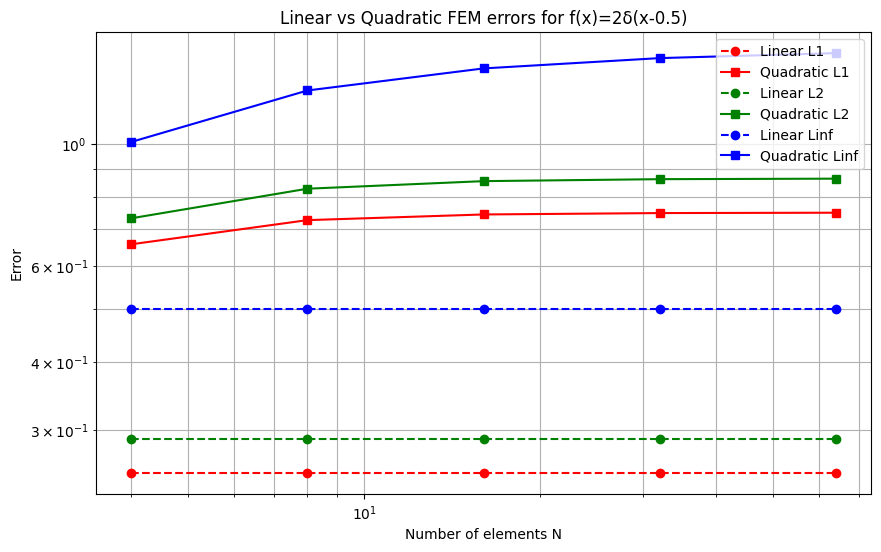

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def grid_linear(N):
    return np.linspace(0, 1, N+1)

def assemble_matrix_linear(L):
    n = len(L)
    K = lil_matrix((n, n))
    for i in range(n-1):
        h = L[i+1]-L[i]
        K[i:i+2, i:i+2] += np.array([[1,-1],[-1,1]])/h
    return K.tocsc()

def rhs_linear_delta(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(n-1):
        if L[i] <= 0.5 <= L[i+1]:
            h = L[i+1]-L[i]
            # distribute delta to linear shape functions
            b[i] += 2*(L[i+1]-0.5)/h
            b[i+1] += 2*(0.5-L[i])/h
    return b

def FEM1DLinearDelta(N):
    L = grid_linear(N)
    K = assemble_matrix_linear(L)
    b = rhs_linear_delta(L)
    u = np.zeros(len(L))
    free = np.arange(1,len(L)-1)
    u[free] = spsolve(K[free,:][:,free], b[free])
    # Analytical solution
    u_exact = np.where(L<=0.5, L, 1-L)
    return L, u, u_exact

def grid_quadratic(N):
    nodes = np.linspace(0,1,N+1)
    mid_nodes = (nodes[:-1]+nodes[1:])/2
    all_nodes = np.sort(np.concatenate([nodes, mid_nodes]))
    return all_nodes

def assemble_matrix_quadratic(L):
    n = len(L)
    K = lil_matrix((n,n))
    for i in range(0,n-2,2):
        h = L[i+2]-L[i]
        Ke = (1/h)*np.array([[7,-8,1],[-8,16,-8],[1,-8,7]])/3.0
        K[i:i+3,i:i+3] += Ke
    return K.tocsc()

def rhs_quadratic_delta(L):
    n = len(L)
    b = np.zeros(n)
    for i in range(0,n-2,2):
        x0,x1,x2 = L[i],L[i+1],L[i+2]
        h = x2 - x0
        if x0 <= 0.5 <= x2:
            # distribute delta according to quadratic shape functions at midpoint xi=0
            b[i] += 0.5 * 2   # left node
            b[i+1] += 1.0 * 2 # mid node
            b[i+2] += 0.5 * 2 # right node
    return b

def FEM1DQuadraticDelta(N):
    L = grid_quadratic(N)
    K = assemble_matrix_quadratic(L)
    b = rhs_quadratic_delta(L)
    u = np.zeros(len(L))
    free = np.arange(1,len(L)-1)
    u[free] = spsolve(K[free,:][:,free], b[free])
    u_exact = np.where(L<=0.5, L, 1-L)
    return L, u, u_exact

def quadratic_interpolate(x0,x1,x2,u0,u1,u2,X):
    h = x2 - x0
    xi = 2*(X - x0)/h - 1
    phi0 = xi*(xi-1)/2
    phi1 = 1 - xi**2
    phi2 = xi*(xi+1)/2
    return u0*phi0 + u1*phi1 + u2*phi2

def L1_error(X, U, Uexact):
    dx = X[1]-X[0]
    return np.sum(np.abs(U-Uexact))*dx

def L2_error(X, U, Uexact):
    dx = X[1]-X[0]
    return np.sqrt(np.sum((U-Uexact)**2)*dx)

def Linf_error(U, Uexact):
    return np.max(np.abs(U-Uexact))

Ns = [4,8,16,32,64]
Xfine = np.linspace(0,1,5000)
Uexact_fine = np.where(Xfine<=0.5, Xfine, 1-Xfine)

errors_linear = {'L1':[],'L2':[],'Linf':[]}
errors_quad   = {'L1':[],'L2':[],'Linf':[]}

for N in Ns:
    # Linear
    L,u,u_exact = FEM1DLinearDelta(N)
    Ufine_linear = np.interp(Xfine, L, u)
    errors_linear['L1'].append(L1_error(Xfine,Ufine_linear,Uexact_fine))
    errors_linear['L2'].append(L2_error(Xfine,Ufine_linear,Uexact_fine))
    errors_linear['Linf'].append(Linf_error(Ufine_linear,Uexact_fine))
    
    # Quadratic
    L,u,u_exact = FEM1DQuadraticDelta(N)
    Ufine_quad = np.zeros_like(Xfine)
    for i in range(0,len(L)-2,2):
        mask = (Xfine>=L[i]) & (Xfine<=L[i+2])
        Ufine_quad[mask] = quadratic_interpolate(L[i],L[i+1],L[i+2],
                                                 u[i],u[i+1],u[i+2],
                                                 Xfine[mask])
    errors_quad['L1'].append(L1_error(Xfine,Ufine_quad,Uexact_fine))
    errors_quad['L2'].append(L2_error(Xfine,Ufine_quad,Uexact_fine))
    errors_quad['Linf'].append(Linf_error(Ufine_quad,Uexact_fine))

plt.figure(figsize=(10,6))
for key,color in zip(['L1','L2','Linf'],['r','g','b']):
    plt.loglog(Ns, errors_linear[key],'o--',color=color,label=f'Linear {key}')
    plt.loglog(Ns, errors_quad[key],'s-',color=color,label=f'Quadratic {key}')

plt.xlabel('Number of elements N')
plt.ylabel('Error')
plt.title('Linear vs Quadratic FEM errors for f(x)=2δ(x-0.5)')
plt.grid(True, which='both')
plt.legend()
plt.show()


**Quadratic FEM may or may not appear more accurate than linear here:**  

The quadratic shape functions distribute the delta over three nodes in the element.  

If the element is not aligned with the delta, the quadratic interpolation can actually spread the error, making the $L^2$ or $L^\infty$ errors sometimes slightly larger than in the linear case.
